# Hands-On Black-Scholes model

In this assingment, random Gaussian numbers will be generated as well they will be used in order to apply Black-Scholes model for vanilla options pricing. Two options will be valuated, an european call option and an european put option, both with maturity $T$. It's required to estimate the value with the given condition:

\begin{equation}
V_call=e^{-r_ct}\cdot E_{RNM}[payoff]=(1+r)^{-t}\cdot E_{RNM}[payoff]
\end{equation}


Using the Black-Scholes equation as follows:

\begin{equation}
V_call(S,t)=S\cdot e^{-d_c}\cdot \phi(d_1)-K2^{-r_ct}\cdot \phi(d_2)
\end{equation}

where:
\begin{equation}
d_1=\frac{1}{\sigma \sqrt{t}}\cdot [ln(S/K)+(r_c-d_c+0.5\sigma^2)t]
\end{equation}
\begin{equation}
d_2=d_1-\sigma\sqrt{t}
\end{equation}



$r=0.03\%; Strike=14; Period: T=1,2,3$ years$; \sigma=0.3; S_0=14$

The variance of the estimated value is:
\begin{equation}
S_{call}^2=(e^{-r_ct})^2\cdot S^{2/payoff}
\end{equation}

## 1. Pseudo-random number generators

In [1]:
from math import *
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew, pearsonr, norm, t
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


### 1.1 Congruential

In [2]:
def congru(seed, m=((2**31)-1), a=16807, b=0):
        y=(a*seed+b)%m
        u=y/m
        return(u, y)

### 1.2 Box-Muller

In [3]:
def boxmuller(seed, mu=0, sigma=1):
    u1, seed=congru(seed)    #Uniform inputs
    u2, seed=congru(seed)
    
    x=sqrt(-2*log(u1))*cos(2*pi*u2)*sigma+mu  #Gaussian numbers generation
    y=sqrt(-2*log(u1))*sin(2*pi*u2)*sigma+mu
    
    antx=sqrt(-2*log(1-u1))*cos(2*pi*(1-u2))*sigma+mu  #Antithetic numbers generation
    anty=sqrt(-2*log(1-u1))*sin(2*pi*(1-u2))*sigma+mu
    return(x, y, u1, u2, antx, anty, seed)

### 1.3 Marsaglia

In [4]:
def marsaglia(seed, mu=0, sigma=1, mode='normal'):
    
    while True:
        if mode=='normal':
            u1, seed= congru(seed)
            u2, seed= congru(seed)
            v1=2*u1-1
            v2=2*u2-1
            R2=v1**2+v2**2
            if R2<=1:
                y=sqrt(-2*log(R2)/R2)
                x1=v1*y*sigma+mu
                x2=v2*y*sigma+mu
                break
        if mode=='antithetic':
            u1, seed= congru(seed)
            u2, seed= congru(seed)
            v1=2*(1-u1)-1
            v2=2*(1-u2)-1
            R2=v1**2+v2**2
            if R2<=1:
                y=sqrt(-2*log(R2)/R2)
                x1=v1*y*sigma+mu
                x2=v2*y*sigma+mu
                break
        
    return(x1,x2,seed)

## 2. Random numbers

In this section, 1k random Gaussian numbers will be generated to be used in following sections. Those number will be obatained by two different methods, Box-Müller and Marsaglia. These methods produce 4 random Gaussian numbers sets each, 2 of those will be generated from antithetic uniform random numbers.

### 2.1 B-M Method

In [5]:
N=1000
coseno=[]
seno=[]
U1=[]
U2=[]
ANcos=[]
ANsin=[]
seed=123456789

for i in range(N):
    x, y, u1, u2, antx, anty, seed=boxmuller(seed)
    coseno.append(x)
    seno.append(y)
    U1.append(u1)
    U2.append(u2)
    ANcos.append(antx)
    ANsin.append(anty)
    
randsBM=pd.DataFrame({'U1': U1,         #Uniform set #1
                    'U2': U2,           #Uniform set #2                    
                    'NormCos': coseno,  #Normal set by cos
                    'NormSen': seno,    #Normal set by sin
                    'AntithCos': ANcos, #Antithetic set by cos
                    'AntithSin': ANsin  #Antithetic set by sin
                  })
print('')
print(color.BOLD + 'Random numbers generated by Box-Müller method:'+ color.END )
display(randsBM.head(11))


Random numbers generated by Box-Müller method:


,U1,U2,NormCos,NormSen,AntithCos,AntithSin
0,0.218418,0.956318,1.679040,-0.472769,0.675770,0.190277
1,0.829509,0.561695,-0.566060,-0.231124,-1.741431,0.711032
2,0.415307,0.066119,1.212934,0.535037,0.947896,-0.418126
3,0.257578,0.109957,1.269381,1.049543,0.594815,-0.491802
4,0.043829,0.633966,-1.666087,-1.865228,-0.199448,0.223288
5,0.061727,0.449539,-2.242464,0.735809,-0.339180,-0.111293
6,0.401306,0.754673,0.039675,-1.350736,0.029740,1.012485
7,0.797287,0.001838,0.673068,0.007775,1.786478,-0.020636
8,0.897504,0.350752,-0.275127,0.374940,-1.262745,-1.720854
9,0.094545,0.013617,2.164005,0.185600,0.444054,-0.038085


### 2.2 Marsaglia method

In [6]:
d=1000
seed=123456789
mu=0
sigma=1
v1=[]
v2=[]
for i in range(d):
    x1, x2, seed = marsaglia(seed, mu, sigma, 'normal')
    v1.append(x1)
    v2.append(x2)
    
antv1=[]
antv2=[]
seed=123456789
for i in range(d):
    x1, x2, seed = marsaglia(seed, mu, sigma, 'antithetic')
    antv1.append(x1)
    antv2.append(x2)
    
randsMs=pd.DataFrame({
                      'Norm1': v1,      #Normal set by cos
                      'Norm2': v2,      #Normal set by sin
                      'Antith1': antv1, #Antithetic set by cos
                      'Antith2': antv2  #Antithetic set by sin
                    })

print('')
print(color.BOLD + 'Random numbers generated by Marsaglia method:'+ color.END )
display(randsMs.head(11))


Random numbers generated by Marsaglia method:


,Norm1,Norm2,Antith1,Antith2
0,1.242957,0.232724,-1.242957,-0.232724
1,-0.134458,-0.688826,0.134458,0.688826
2,-0.307862,-0.495332,0.307862,0.495332
3,-0.430708,0.126488,0.430708,-0.126488
4,-0.702977,-0.080938,0.702977,0.080938
5,-0.561967,1.450124,0.561967,-1.450124
6,0.757011,-0.284229,-0.757011,0.284229
7,0.143902,0.136589,-0.143902,-0.136589
8,-0.217714,0.374654,0.217714,-0.374654
9,-0.811921,-0.311816,0.811921,0.311816


## 3. Black-Scholes equation

In this section, the pricing two options is made by means of Black-Scholes equation as described at the beginning of this document.

### 3.1 Initial Data

In [7]:
# Underlying price at the begining
S0=14
# Strike price
Str=14

# Yearly and continous return
ry=0.03
rc=log(1+ry)

# Yearly and continuos discount rate
dy=0
dc=log(1+dy)

# Volatility
sig=0.3
#Period
T=1

# d1 and d2
d1=(np.log(S0/Str)+(rc-dc+0.5*sig**2))*T/(sig*np.sqrt(T))
d2=d1-sig*np.sqrt(T)

# Accumulated gaussian probability
phi1=norm.cdf(d1)
phi2=norm.cdf(d2)


### 3.2 Black-Scholes

In [8]:
Vcall=S0*np.exp(-1*dc*T)*phi1-Str*np.exp(-1*rc*T)*phi2
Vput=Vcall-S0*np.exp(-1*dc*T)+Str*np.exp(-1*rc*T)
print(color.BOLD + 'The call and put values are:'+ color.END )
print(color.BOLD + ' Vcall =' + color.END,Vcall)
print(color.BOLD + ' Vput  =' + color.END ,Vput)

The call and put values are:
 Vcall = 1.8567867063017554
 Vput  = 1.4490197160104934


### 3.3 Pay-Off 

In [11]:
Ss=[]
for gvalue in seno:
    S=S0*np.exp((rc-dc-0.5*sig**2)*T+sig*np.sqrt(T)*gvalue)
    Ss.append(S)

payoffc=[]
payoffp=[]
for S in Ss:
    if (S >S0):
        payoffc.append(S-S0)
        payoffp.append(0)
    else:
        payoffc.append(0)
        payoffp.append(S0-S)

po=pd.DataFrame({
                      'Sc': Ss,                #Underlying price along the time series
                      'Payoffc': payoffc,      #Payoff along the time series
                      'Payoffp': payoffp 
                    })

poAVGc=np.mean(payoffc)
poVARc=np.var(payoffc,ddof=1)
poACCc=t.ppf(1-0.05/2,N-1)*np.sqrt(poVARc/1000)

VavgC=poAVGc*np.exp(-1*rc*T)
VvarC=poVARc*np.exp(-2*rc*T)
VaccC=t.ppf(1-0.05/2,N-1)*np.sqrt(VvarC/1000)

poAVGp=np.mean(payoffp)
poVARp=np.var(payoffp,ddof=1)
poACCp=t.ppf(1-0.05/2,N-1)*np.sqrt(poVARp/1000)

VavgP=poAVGp*np.exp(-1*rc*T)
VvarP=poVARp*np.exp(-2*rc*T)
VaccP=t.ppf(1-0.05/2,N-1)*np.sqrt(VvarP/1000)


index=['mean', 'variance', 'accuracy']
metricsc=pd.DataFrame({
                      'Pay-off': np.array([poAVGc, poVARc, poACCc]),
                      'Value': np.array([VavgC, VvarC, VaccC])
                    }, index=index)

metricsp=pd.DataFrame({
                      'Pay-off': np.array([poAVGp, poVARp, poACCp]),
                      'Value': np.array([VavgP, VvarP, VaccP])
                    }, index=index)


print('')
print(color.BOLD + 'Metrics for call option:')
display( metricsc)
print('')
print(color.BOLD + 'Metrics for put option:')
display(metricsp)


Metrics for call option:


,Pay-off,Value
mean,1.977436,1.919841
variance,10.678826,10.065818
accuracy,0.202785,0.196879



Metrics for put option:


,Pay-off,Value
mean,1.457186,1.414743
variance,3.835595,3.615416
accuracy,0.121532,0.117992


[13.42109313713158,
 13.704916351842567,
 14.645104831458758,
 15.312410211537422,
 11.896415114727025,
 14.901971448879388,
 12.438461808092647,
 13.991414395281886,
 14.443454603356942,
 14.208551188236797,
 13.43157086643617,
 14.099430123103774]

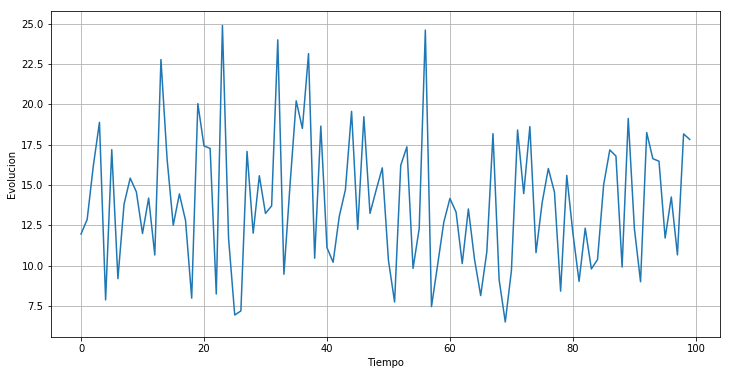

In [25]:
plt.figure(figsize=(12,6))
ejex=range(100)
plt.plot(ejex,Ss[0:100])
plt.grid()
plt.xlabel('Tiempo')
plt.ylabel('Evolucion')

d=12
dt=T/12


j=1
i=0

tm=[]
for i in range(d):
    te=S0*np.exp((rc-dc-0.5*sig**2)*dt+sig*np.sqrt(dt)* seno[(j-1)*d+i])
    tm.append(te)
tm

In [ ]:
len(Ss)